## Welcome

This is material for the **Probability and Regression** chapter in Scott Cunningham's book, [Causal Inference: The Mixtape.](https://mixtape.scunning.com/)

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

# Read data
def read_data(file):
    return pd.read_csv("https://raw.github.com/scunning1975/mixtape/master/" + file)

## OLS

In [3]:
# Set seed
np.random.seed(1)

# Set observations
obs = 10000

# Construct dataset
tb = pd.DataFrame({
    'x': np.random.normal(size = obs),
    'u': np.random.normal(size = obs)})

tb['y'] = 5.5*tb['x'].values + 12*tb['u'].values

In [5]:
# Fit model
reg_tb = sm.OLS.from_formula('y ~ x', data = tb).fit()

# Show model summary
print(reg_tb.params)

# Construct variables
tb['yhat1'] = reg_tb.predict(tb)
tb['yhat2'] = reg_tb.params[0] + reg_tb.params[1]*tb['x']
tb['uhat1'] = reg_tb.resid
tb['uhat2'] = tb['y'] - tb['yhat2']

# Describe dataset
tb.describe()

Intercept    0.111381
x            5.688663
dtype: float64

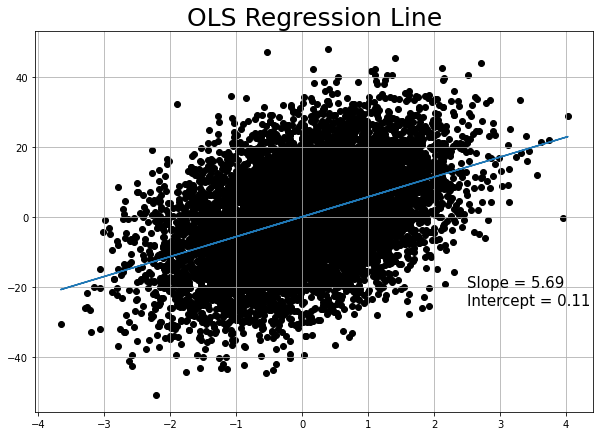

In [29]:
# Create figure
fig, ax = plt.subplots(figsize = (10, 7))

# Add scatterplot
plt.scatter(tb.x, tb.y, color = 'black')

# Create line-of-best fit and add to plot
m, b = np.polyfit(tb.x, tb.y, deg = 1)
ax.plot(tb.x, m*tb.x + b)

# Display slope and intercept on plot
ax.text(2.5, -20, "Slope = {:.2f}".format(m), size = 15)
ax.text(2.5, -25, "Intercept = {:.2f}".format(b), size = 15)

# Customize the plot by adding title and gridlines
ax.set_title('OLS Regression Line', size = 25)
ax.grid()

# Show plot
plt.show()

#### Questions:

-   What is the predicted value of $y$ when $x = 0$?
-   How much do we estimate $y$ increases by when $x$ increases by one unit?
-   Assume we y was the natural log of some variable, and x was the natural log of some variable.  How do we interpret the coefficient on $x$ if it is a log-log regression?

In [40]:
# Set seed
np.random.seed(1)

# Set observations
obs = 10

# Construct dataset
tb2 = pd.DataFrame({
    'x': 9*np.random.normal(size = obs),
    'u': 36*np.random.normal(size = obs)})
tb2['y'] = 3*tb2['x'].values + 2*tb2['u'].values

# Fit model
reg_tb2 = sm.OLS.from_formula('y ~ x', data = tb2).fit()

tb2['yhat1'] = reg_tb2.predict(tb2)
tb2['uhat1'] = reg_tb2.resid

# Describe dataset
tb2.describe()

,x,u,y,yhat1,uhat1
count,10.000000,10.000000,10.000000,10.000000,1.000000e+01
mean,-0.874268,-6.105182,-14.833168,-14.833168,-7.105427e-15
std,11.297856,37.914691,101.335642,83.608653,5.725823e+01
min,-20.713848,-74.165066,-164.847554,-161.654001,-1.157391e+02
25%,-6.514599,-27.158666,-76.974311,-56.573870,-1.883015e+01
50%,-3.498940,-8.907217,-12.910615,-34.256787,1.319349e+01
75%,6.559339,16.115934,35.096043,40.178503,4.277999e+01
max,15.703306,52.635886,149.129096,107.847514,6.020189e+01


#### Questions

-   What is the average of the residuals $\hat{u}$ from our regression?

In [41]:
# Set seed
np.random.seed(1)

# Run 1000 simulations of OLS
coefs = np.zeros(1000)
for i in range(1000):
    tb2 = pd.DataFrame({
    'x': 9*np.random.normal(size=10000),
    'u': 36*np.random.normal(size=10000)})
    tb2['y'] = 3 + 2*tb2['x'].values + tb2['u'].values

    reg_tb2 = sm.OLS.from_formula('y ~ x', data = tb2).fit()

    coefs[i] = reg_tb2.params['x']

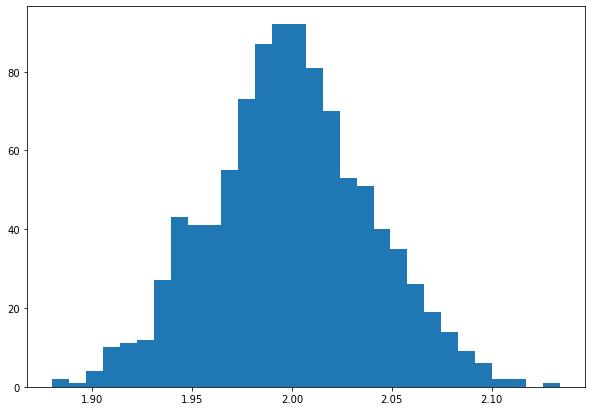

In [42]:
# Make histogram plot
fig, ax = plt.subplots(figsize = (10, 7))

ax.hist(x = coefs, bins = 30)

plt.show()

#### Questions

-   Explain the concept of unbiasedness in the context of this simulation?  
-   On average, do we think the estimate is close to the true value of $\beta_1 = 2$?

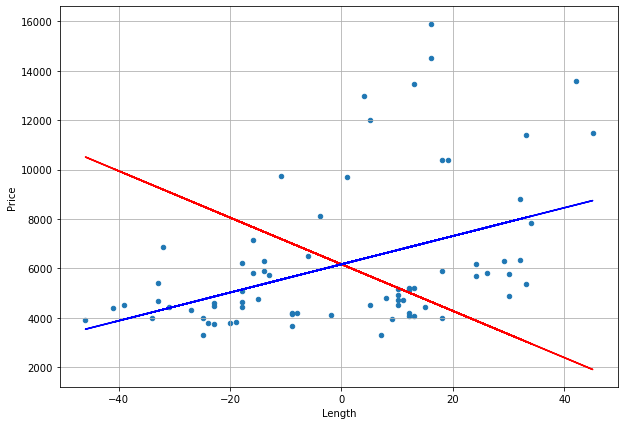

In [43]:
# Load data
auto = pd.read_stata('https://raw.github.com/scunning1975/mixtape/master/auto.dta')
auto['length'] = auto['length'] - auto['length'].mean()

# Fit models
lm1 = sm.OLS.from_formula('price ~ length', data = auto).fit()
lm2 = sm.OLS.from_formula('price ~ length + weight + headroom + mpg', data = auto).fit()

# Extract parameters
coef_lm1 = lm1.params
coef_lm2 = lm2.params
resid_lm2 = lm2.resid

# Construct variables
auto['y_single'] = coef_lm1[0] + coef_lm1[1] * auto['length']
auto['y_multi'] = coef_lm1[0] + coef_lm2[1] * auto['length']

# Create figure
fig, ax = plt.subplots(figsize = (10, 7))
# Add scatterplot of length vs. price
auto.plot(kind = "scatter", x = 'length', y = 'price', ax = ax)
# Create the lines-of-best-fit and add them to the plot
m1, b1 = np.polyfit(x = auto['length'], y = auto['y_multi'], deg = 1)
ax.plot(auto['length'], m1 * auto['length']  + b1, color = 'red')

m2, b2 = np.polyfit(x = auto['length'], y = auto['y_single'], deg = 1)
ax.plot(auto['length'], m2 * auto['length']  + b2, color = 'blue')

#Customize the figure by adding gridlines and setting axis labels
ax.grid()
ax.set_xlabel('Length')
ax.set_ylabel('Price')

# Show figure
plt.show()

#### Questions

-   What happened to the coefficient on length after controlling for weight, headroom, and mpg in the regression?

## Clustering Standard Errors

### Cluster robust standard errors

People will try to scare you by challenging how you constructed your standard errors. Heteroskedastic errors, though, aren't the only thing you should be worried about when it comes to inference. Some phenomena do not affect observations individually, but they do affect groups of observations that involve individuals. And then they affect those individuals within the group in a common way. Say you want to estimate the effect of class size on student achievement, but you know that there exist unobservable things (like the teacher) that affect all the students equally. If we can commit to independence of these unobservables across classes, but individual student unobservables are correlated within a class, then we have a situation in which we need to cluster the standard errors. Before we dive into an example, I'd like to start with a simulation to illustrate the problem.

As a baseline for this simulation, let's begin by simulating nonclustered data and analyze least squares estimates of that nonclustered data. This will help firm up our understanding of the problems that occur with least squares when data is clustered.

First, I will create a function to generate our Monte Carlo simulation.

In [ ]:
def gen_cluster(param = (.1, .5), n = 1000, n_cluster = 50, rho = .5):
    # Function to generate clustered data

    # individual level
    Sigma_i = np.array((1, 0, 0, 1 - rho)).reshape(2,2)

    values_i = np.random.multivariate_normal(np.zeros(2), Sigma_i, size = n)

    # cluster level
    cluster_name = np.repeat(np.arange(1, n_cluster+1), repeats = n / n_cluster)
    Sigma_cl = np.array((1, 0, 0, rho)).reshape(2,2)
    values_cl = np.random.multivariate_normal(np.zeros(2),Sigma_cl, size = n_cluster)

    # predictor var consists of individual- and cluster-level components
    x = values_i[: , 0] + np.repeat(values_cl[: , 0], repeats = n / n_cluster)

    # error consists of individual- and cluster-level components
    error = values_i[: , 1] + np.repeat(values_cl[: , 1], repeats = n / n_cluster)

    # data generating process
    y = param[0] + param[1]*x + error
    
    df = pd.DataFrame({'x':x, 'y':y, 'cluster': cluster_name})
    return df


In [ ]:
def cluster_sim(param = (.1, .5), n = 1000, n_cluster = 50,
                        rho = .5, cluster_robust = False):

    df = gen_cluster(param = param, n = n , n_cluster = n_cluster, rho = rho)

    if not cluster_robust:
        fit = sm.OLS.from_formula('y ~ x', data = df).fit()
    else: # cluster-robust SE
        fit = sm.OLS.from_formula('y ~ x', data = df).fit(cov_type='cluster', cov_kwds={'groups': df['cluster']})
    
    b1 = fit.params[1]
    Sigma = fit.cov_params()   
    
    se = np.sqrt(np.diag(Sigma)[1])
    ci95 = se*1.96
    b1_ci95 = (b1-ci95, b1+ci95)


    return (b1, se, *b1_ci95)


In [ ]:
n_sims = 1000
param = (.1, .5)
n = 1000
n_cluster = 50
rho = .5
cluster_robust = True

In [ ]:
def run_cluster_sim(n_sims = 1000, param = (.1, .5), n = 1000,
                            n_cluster = 50, rho = .5, cluster_robust = False):

    res = [cluster_sim(param = param, n = n, rho = rho,
                                      n_cluster = n_cluster,
                                      cluster_robust = cluster_robust) for x in range(n_sims)]
    df = pd.DataFrame(res)
    df.columns = ('b1', 'se_b1', 'ci95_lower', 'ci95_upper')
    df['param_caught'] = (df['ci95_lower'] <= param[1]) & (param[1] <= df['ci95_upper'])
    df['id'] = df.index
    return df


In [ ]:
# Simulation no clustered SE
sim_params = [.4, 0] # beta1 = 0: no effect of x on y
sim_nocluster = run_cluster_sim(n_sims=1000, param = sim_params, rho=0, cluster_robust = False)

In [ ]:
p.ggplot(sim_nocluster, p.aes('b1')) +\
  p.geom_histogram(color = 'black') +\
  p.geom_vline(xintercept = sim_params[1], color = 'red')

In [ ]:
sim_nocluster.sample(100).sort_values('b1')

In [ ]:
p.ggplot(sim_nocluster.sample(100).sort_values('b1'),
                         p.aes(x = 'factor(id)', y = 'b1', 
                             ymin = 'ci95_lower', ymax = 'ci95_upper',
                             color = 'param_caught')) +\
  p.geom_hline(yintercept = sim_params[1], linetype = 'dashed') +\
  p.geom_pointrange() +\
  p.labs(x = 'sim ID', y = 'b1', title = 'Randomly Chosen 100 95% CIs') +\
  p.scale_color_discrete(name = 'True param value', labels = ('missed', 'hit')) +\
  p.coord_flip()

In [ ]:
1 - sum(sim_nocluster.param_caught)/sim_nocluster.shape[0]

#### Questions:

-   What point does the least squares estimate appear to be centered on?
-   Setting the significance level at 5%, we should incorrectly reject the null that $\beta_1=0$ about 5% of the time in our simulations. About what percent of the time does the 95% confidence intervals contain the true value of $\beta_1 = 0$?

### Case 2: Clustered Data

Now let's resimulate our data with observations that are no longer independent draws in a given cluster of observations, but the true value of $\beta_1$ still is 0.

In [ ]:
# Simulation clustered SE
sim_params = [.4, 0] # beta1 = 0: no effect of x on y
sim_nocluster = run_cluster_sim(n_sims=1000, param = sim_params, cluster_robust = False)

In [ ]:
p.ggplot(sim_nocluster, p.aes('b1')) +\
  p.geom_histogram(color = 'black') +\
  p.geom_vline(xintercept = sim_params[1], color = 'red')

In [ ]:
p.ggplot(sim_nocluster.sample(100).sort_values('b1'),
                         p.aes(x = 'factor(id)', y = 'b1', 
                             ymin = 'ci95_lower', ymax = 'ci95_upper',
                             color = 'param_caught')) +\
  p.geom_hline(yintercept = sim_params[1], linetype = 'dashed') +\
  p.geom_pointrange() +\
  p.labs(x = 'sim ID', y = 'b1', title = 'Randomly Chosen 100 95% CIs') +\
  p.scale_color_discrete(name = 'True param value', labels = ('missed', 'hit')) +\
  p.coord_flip()

In [ ]:
1 - sum(sim_nocluster.param_caught)/sim_nocluster.shape[0]

#### Questions:

-   When the errors are clustered, does the distribution of $\hat{\beta}_1$ estimates get wider or narrower?
-   When the errors are clustered, do we incorrectly reject the null more or less frequently?